### ASTR 3970 / 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 4
### Due: Saturday, Feb 15th at 11.59pm CST
---

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3.5 to 6.5. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to $\mu+\sigma_\mathrm{mean}$ and $\mu-\sigma_\mathrm{mean}$. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.5 to 5.5. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6.1\pm0.25$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6.1$ with standard deviation of $0.25$.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

### Solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy

In [2]:
#1
info = np.load('./hw_data/hw4_data_1.npy')

#Descriptions Same as hw3
first = info[0:10,0]/(info[0:10,1])**2
second = 1/(info[0:10,1])**2

#Final part
mu = np.sum(first)/np.sum(second)
sigmu = np.sqrt(1/np.sum(second))

print('Mean is', mu)
print('Standard error is',sigmu)

Mean is 4.942118214425304
Standard error is 0.43024334605205083


In [12]:
#2
#Data
val = info[:,0] #For ease, turned each column into it's own array
sig = info[:,1]

#Functions
L = math.log(1/math.sqrt(math.pi)*2*np.std(val)**2)  #Normalization constant for later use
def LogL(v,m,s):
    return -(L-np.sum(0.5*((v-m)**2/(s**2)))) #This is the log likeliness function as given in lecture
def Likely(x,m,s):
    return np.prod(np.exp(L)*np.exp(-0.5*((x-m)**2)/(s**2)))

#Lambda Function
f = lambda mean: LogL(val, mean, sig) #Lambda function to optimize

#Final
mean0 = 1 #Guess value
max = scipy.optimize.fmin(f,mean0)
print('The best fit mean is',max[0])

Optimization terminated successfully.
         Current function value: 2.716408
         Iterations: 20
         Function evaluations: 40
The best fit mean is 4.942089843750008


SRT: Correct answer, but your Gaussian likelihood normalization constant is not correct. It does not affect it here, but it may affect your answer later on. -2 points

Correct form should be:

In [ ]:
L = math.log(1/math.sqrt(math.pi*2*sig**2))
# This is for each observation, and it should be included in the product operation.

In [ ]:
# Easier
#(2)
def lnlike(vi, sigmai, mu):
    return np.sum(norm.logpdf(vi, loc=mu, scale=sigmai))

f_lnlike = lambda beta: -lnlike(vi, sigmai, beta)

# compute the maximum likelihood 
beta0 = 1.0 # initial guess for a and b
beta_squared = scipy.optimize.fmin(f_lnlike, beta0)
print("Estimated mean is %.4f" % beta_squared[0])

In [11]:
#Functions for #3 & 4
def prior(loc,scale,x):
    distmu = scipy.stats.uniform(loc = loc, scale = scale) #Simple uniform distribution prior
    return distmu.pdf(x)
def post(dist,loc,scale,mu,s):
    Cool = np.array([Likely(dist,mu_,s)*prior(loc,scale,mu_) for mu_ in mu])#Creates an array that takes every single point on the posterior across mu
    Cool /= np.sum(Cool*(m[1]-m[0])) #Normalizing via definition of a integral (Sum over interavl with account of change in x)
    return Cool
def invcdf(data,point):
    this = np.argmin(np.abs(np.cumsum(data)-point)) #This finds the point closest to the % region through taking the different then the absolute value
    return this

Integral sum is 0.9999999999999998
Maximum Posterior is 4.944944944944945
Difference in errors are -0.010197094388389338 -0.009822925631630675


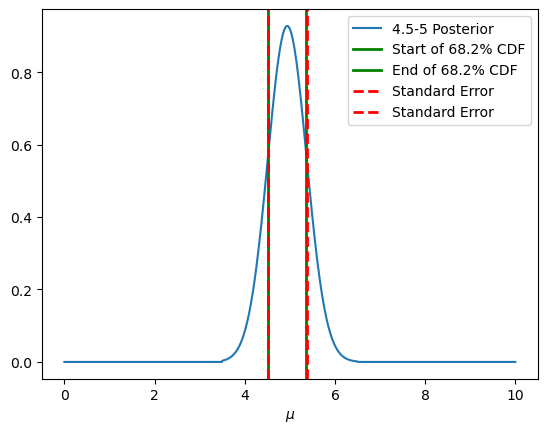

In [39]:
#3
m = np.linspace(0,10,1000) #Range

C3 = post(val,3.5,3,m,sig)

#Plots
plt.plot(m,C3,label ='4.5-5 Posterior')
plt.xlabel(r'$\mu$')
print('Integral sum is', np.sum(C3*(m[1]-m[0]))) #Proof of normalization

#4 Finding the max and ranges
plt.axvline(m[invcdf(C3*(m[1]-m[0]),0.159)], color = 'green', linewidth = 2.0, label = 'Start of 68.2% CDF')
plt.axvline(m[invcdf(C3*(m[1]-m[0]),0.841)], color = 'green', linewidth = 2.0, label = 'End of 68.2% CDF')
plt.axvline(m[np.argmax(C3)]-sigmu, color = 'red', linestyle = '--', linewidth = 2.0, label = 'Standard Error')
plt.axvline(m[np.argmax(C3)]+sigmu, color = 'red', linestyle = '--', linewidth = 2.0, label = 'Standard Error')
plt.legend()

#Final Part
print('Maximum Posterior is', m[np.argmax(C3)]) #Max
print('Difference in errors are', m[invcdf(C3*(m[1]-m[0]),0.159)]-(m[np.argmax(C3)]-sigmu),m[invcdf(C3*(m[1]-m[0]),0.841)]-(m[np.argmax(C3)]+sigmu)) #They are very similiar, effectively the same

SRT: Good. I would have liked a statement of what the locations of the vertical credible lines are though. -1 point

Integral sum is 1.0
MAP is 4.944944944944945
Difference in errors are 0.15997307578178077 -0.09991301572172073


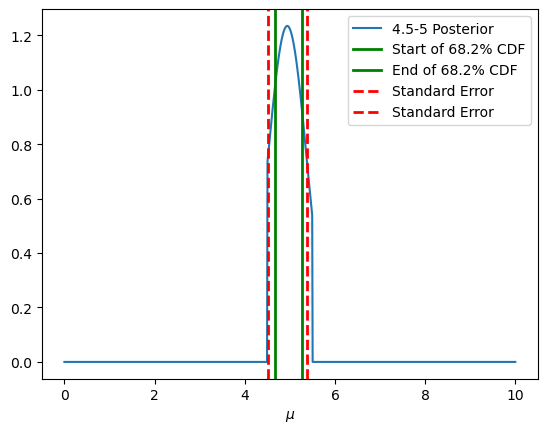

In [40]:
#5
#Plotting Distribution
C4 = post(val,4.5,1,m,sig) #New values easy change
plt.plot(m,C4, label ='4.5-5 Posterior')
plt.xlabel(r'$\mu$')
print('Integral sum is',np.sum(C4*(m[1]-m[0]))) #Proof of normalization

#Same function different values
plt.axvline(m[invcdf(C4*(m[1]-m[0]),0.159)], color = 'green', linewidth = 2.0, label = 'Start of 68.2% CDF')
plt.axvline(m[invcdf(C4*(m[1]-m[0]),0.841)], color = 'green', linewidth = 2.0, label = 'End of 68.2% CDF')
plt.axvline(m[np.argmax(C4)]-sigmu, color = 'red', linestyle = '--', linewidth = 2.0, label = 'Standard Error')
plt.axvline(m[np.argmax(C4)]+sigmu, color = 'red', linestyle = '--', linewidth = 2.0, label = 'Standard Error')
plt.legend()

#Final Part
print('MAP is', m[np.argmax(C4)])
print('Difference in errors are', m[invcdf(C4*(m[1]-m[0]),0.159)]-(m[np.argmax(C4)]-sigmu),m[invcdf(C4*(m[1]-m[0]),0.841)]-(m[np.argmax(C4)]+sigmu)) #Differences are more noticable now, both visually and arithmetically

In [7]:
#6 Functions
def normPrior(mu,sig,x): #Prior with a normal distribution instead :D
    distmu = scipy.stats.norm(loc = mu, scale = sig)
    return distmu.pdf(x)
def postnorm(dist,loc,scale,mu,s):
    Cool = np.array([Likely(dist,mu_,s)*normPrior(loc,scale,mu_) for mu_ in mu])
    Cool /= np.sum(Cool*(m[1]-m[0]))
    return Cool

1.0
MAP is 5.8058058058058055
Difference in errors are 0.2100231258318308 -0.2200331358418408


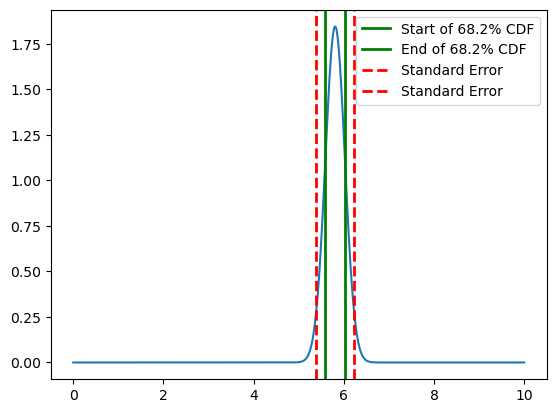

In [43]:
#6
C6 = postnorm(val,6.1,0.25,m,sig) #Same as 4 and 3, just new function that is slightly different
plt.plot(m,C6)
print(np.sum(C6*(m[1]-m[0]))) #Proof of normalization

#Same function different values
plt.axvline(m[invcdf(C6*(m[1]-m[0]),0.159)], color = 'green', linewidth = 2.0, label = 'Start of 68.2% CDF')
plt.axvline(m[invcdf(C6*(m[1]-m[0]),0.841)], color = 'green', linewidth = 2.0, label = 'End of 68.2% CDF')
plt.axvline(m[np.argmax(C6)]-sigmu, color = 'red', linestyle = '--', linewidth = 2.0, label = 'Standard Error')
plt.axvline(m[np.argmax(C6)]+sigmu, color = 'red', linestyle = '--', linewidth = 2.0, label = 'Standard Error')
plt.legend()

#Final Part
print('MAP is', m[np.argmax(C6)])
print('Difference in errors are', m[invcdf(C6*(m[1]-m[0]),0.159)]-(m[np.argmax(C6)]-sigmu),m[invcdf(C6*(m[1]-m[0]),0.841)]-(m[np.argmax(C6)]+sigmu)) #Very different from the standard error

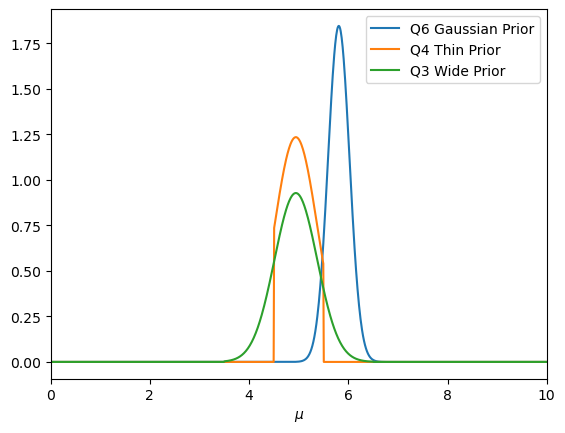

In [42]:
plt.xlim(0,10)
plt.plot(m,C6, label = 'Q6 Gaussian Prior')
plt.plot(m,C4, label = 'Q4 Thin Prior')
plt.plot(m,C3, label = 'Q3 Wide Prior')
plt.xlabel('$\mu$')
plt.legend()

SRT: Very good

$$8$$
Note that the definition of the delta function is that the integral of said function with anything other function just gets the function at that value which centers the delta function.

So taking a delta function at the value of mu calculated in problem 1 for the prior, the evidence would be the likelihood at the best fit point

In [44]:
#8
def evidence(dist,loc,scale,mu,s): #Same as posterior function, just made it find the normalization constant
    Cool = np.array([Likely(dist,mu_,s)*prior(loc,scale,mu_) for mu_ in mu])
    Cool = np.sum(Cool*(m[1]-m[0]))
    return Cool
Evidence3 = evidence(val,3.5,3,m,sig)
Evidence8 = Likely(val,mu,sig)
print(Evidence8/Evidence3)

2.7832496267004423


Since the Odds ratio is not really substantial <(1:3), there and considering that a delta function is not really something that exists physically, it is more likely that the uniform prior of 3 is a better fit 

SRT: Interesting interpretation! 

## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. 

We're going to do some polynomial fits to this data just like in `Lecture 9`. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

In [45]:
#Functions to do a polynomial fit, and compute the likelihood
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!

4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension.

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model. 

6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in Lecture 9? 

### Solution

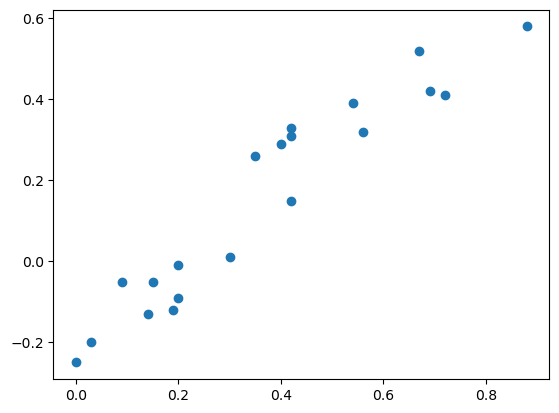

In [46]:
#1
data = np.load('./hw_data/hw4_data_2.npy') #Directory Change for code
x, y, sigma_y = data
plt.scatter(x,y) #Just to show distribution

In [47]:
#2 Function
def linpost(n0,n1,data,loc1,scale1): #simple posterior for only 1D, will be upgraded later
    Post = np.array([np.exp(logL([n0,n1_],data))* prior(loc1,scale1,n1_) for n1_ in n1]) #Same idea as in the previous problem
    return Post

Bayesian Evidence is 365684733.16067535


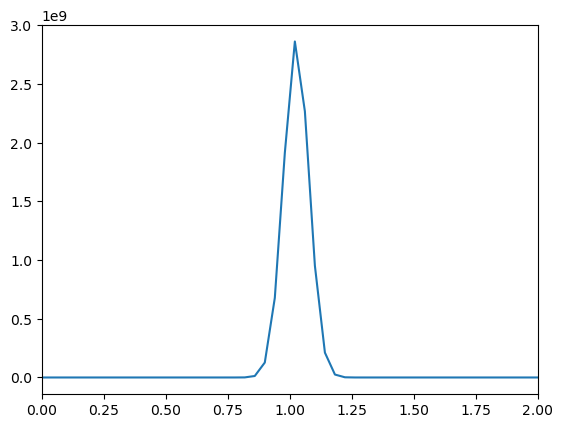

In [53]:
#2 
n = np.linspace(-1,3,100) #Even spacing around the best fit
V = linpost(-0.23,n,data,0.5,1)
plt.plot(n,V) #If you consider this a 1D 
plt.xlim(0,2)

#3
print('Bayesian Evidence is', np.sum(V*(n[1]-n[0]))) #Definetly large

SRT: Looks like this needs more grid points to display a smoother distribution. -1 point

SRT: Correct answer

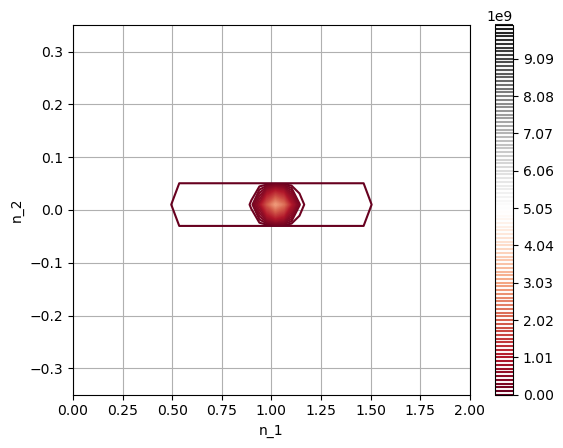

In [25]:
#2 With different grid, wasn't sure what counted as a 1d grid, so I also plotted it as a contour plot just to make sure
level = np.linspace(0,10e9,100) #Lines for asthetics 
#Here is the x and y limits
x = np.linspace(-1,3,100)
y = np.linspace(-1,3,100)

#Turn into a grid
X,Y = np.meshgrid(x,y)

#How to turn it into a line
space = np.linspace(0,0,100)
space[25] = 1

#Make a grid
D,Z=np.meshgrid(V,space)
#Since only one row is non zero at y = 0, this turns the contour plot into just a line
Z1=D*Z

plt.contour(X,Y,Z1, cmap='RdGy', levels = level)
plt.xlabel('n_1')
plt.ylabel('n_2')
plt.ylim(-0.35,0.35)
plt.xlim(0,2)
plt.colorbar()
plt.grid()


SRT: Not sure what the above is meant to show, but looks like you get there in the end.

In [30]:
#4 Function
def linpost2(n0,n1,n2,data,loc1,scale1,loc2,scale2): #Best fit for quadratic, essentially a nested array was used
    Post = np.array([np.array([np.exp(logL([n0,n1_,n2_],data))* prior(loc1,scale1,n1_)*prior(loc2,scale2,n2_) for n1_ in n1])for n2_ in n2])
    return Post

In [31]:
#4, done this here since if I wanted to adjust graph did not want to waste time loading this
V2 = linpost2(-0.23,n,n,data,0.5,1,-1,1.25) #Since 100x100 points are created, this takes some time to do, must be even worse with 3 dimensions 

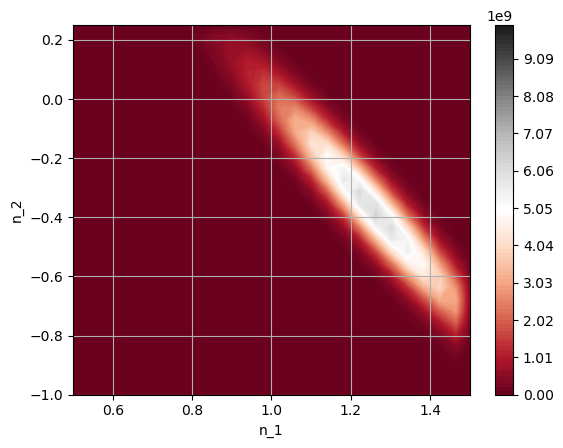

In [32]:
#4 Plotting
plt.contourf(X,Y,V2, cmap='RdGy', levels = level) #Aesthetic
plt.xlim(0.5,1.5) #Captures the important region
plt.ylim(-1,0.25)
plt.xlabel('n_1')
plt.ylabel('n_2')
plt.colorbar()
plt.grid()

SRT: Good! I like the color scheme too.

In [65]:
#5
QuadEvidence = np.sum(V2*(n[1]-n[0])**2), #Note that since this integrating along two dimensions you have to square the deltax as its and area now
print('Bayesian Evidence is', QuadEvidence)
#6
LinEvidence = np.sum(V*(n[1]-n[0]))
print('Bayes Factor is =',QuadEvidence/LinEvidence) #Gets the appropriate ratio

Bayesian Evidence is (482444475.82730365,)
Bayes Factor is = [1.31929072]


$$7$$
This while it ultimately gives the same information as the BIC from before, is not quite the same thing, since the BIC for the linear model was definitely smaller than the quadratic, while here the quadratic model is not substantially better than the linear model (Even if the bayes factor is >1), which by Occams razor means that the linear model is likely better

SRT: Excellent, Noah.

SRT: 47/50